# Feature Engineering and EDA

In [1]:
import re
import numpy as np
import pandas as pd
import pickle
import gensim
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

%matplotlib inline

In [123]:
file = open('articles.p', 'rb')      
df = pickle.load(file)
file.close()

In [124]:
drop_indices = df.loc[df['date'] < pd.Timestamp(2019, 3, 15)].index
df.drop(index=drop_indices, inplace=True)

In [125]:
# Drop update articles and investing articles
df = df.loc[df['headline'].map(lambda x: re.search(r'UPDATE', x)).isna()]
df = df.loc[df['headline'].map(lambda x: re.search(r'US STOCKS', x)).isna()]
df = df.loc[df['headline'].map(lambda x: re.search(r'PRESS', x)).isna()]
df = df.loc[df['url'].map(lambda x: re.search(r'investing', x)).isna()]
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)
df.drop(columns='url', inplace=True)

## Add sentences and words features

In [126]:
def replace_words(text):
    text = re.sub(r'U\.S\.', 'US', text)
    text = re.sub(r'US\s', 'USA ', text)
    text = re.sub(r'U\.K\.', 'UK', text)
    text = re.sub(r'Mr\.', 'MR', text)
    text = re.sub(r'Mrs\.', 'MRS', text)
    text = re.sub(r'Ms\.', 'MS', text)
    text = re.sub(r'\.\.\.', '', text)
    text = re.sub(r'U.S-China', 'US-China', text)
    text = re.sub(r'(\.)(\w)', r'\1 \2', text)
    text = text.replace('Co.', 'Co')
    text = text.replace('\xa0', '')
    text = text.replace('."', '".')
    text = text.replace('immediatelywith', 'immediately with')
    text = text.replace('theOfficeof', 'the Office of')
    text = text.replace('theCommissionerof', 'the Commissioner of')
    text = text.replace('entirelywithin', 'entirely within')
    
    return text

In [127]:
df['body'] = df['body'].map(replace_words)

In [128]:
# Modified from: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
def preprocess(text):
    stop_words = stopwords.words('english')
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words:
            result.append(WordNetLemmatizer().lemmatize(token, pos='v'))
    return ' '.join(result)

In [129]:
def preprocess_all(listy):
    results = [ preprocess(text) for text in listy ]
    return results

In [130]:
# Tokenize body sentences, keep first 10 sentences
df['sentence_tokens'] = df['body'].map(lambda x: sent_tokenize(x)[:10])

In [131]:
df['sentences'] = df['body'].map(lambda x: sent_tokenize(x)[:10])

In [132]:
# Preprocess sentences
df['sentence_tokens'] = df['sentence_tokens'].map(preprocess_all)

# Form word tokens from the sentences
df['word_tokens'] = df['sentence_tokens'].map(lambda x: ' '.join(x).split())

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 7 columns):
date               2965 non-null datetime64[ns]
headline           2965 non-null object
body               2965 non-null object
source             2965 non-null object
sentence_tokens    2965 non-null object
sentences          2965 non-null object
word_tokens        2965 non-null object
dtypes: datetime64[ns](1), object(6)
memory usage: 162.3+ KB


## Dictionary and bigram/trigram models
- This section heavily takes from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [134]:
data_words = df['word_tokens']

In [135]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10)
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [136]:
def make_bigrams(texts):
    return [ bigram_mod[doc] for doc in texts ]

def make_trigrams(texts):
    return [ trigram_mod[bigram_mod[doc]] for doc in texts ]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([ token.lemma_ for token in doc if token.pos_ in allowed_postags ])
    return texts_out

In [137]:
def lemmatize_one(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    text_out = []
    text = nlp(text)
    for token in text:
        if token.pos_ in allowed_postags:
            text_out.append(token.lemma_)
    return text_out

In [138]:
# Form Bigrams and Trigrams
data_words_bigrams = make_bigrams(data_words)
data_words_trigrams = make_trigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [139]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter extremes from dictionary
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [ id2word.doc2bow(text) for text in texts ]

In [140]:
# Create TF-IDF corpus
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

## LDA Models

### Standard LDA

In [141]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       workers=2,
                                       num_topics=5, 
                                       random_state=100,
                                       passes=10,
                                       per_word_topics=True)

In [142]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.030*"protester" + 0.018*"police" + 0.013*"student" + 0.013*"people" + '
  '0.011*"government" + 0.011*"city" + 0.010*"rally" + 0.009*"hong_kong" + '
  '0.009*"group" + 0.008*"call"'),
 (1,
  '0.023*"police" + 0.014*"arrest" + 0.011*"case" + 0.011*"court" + '
  '0.008*"charge" + 0.007*"hong_kong" + 0.007*"student" + 0.007*"also" + '
  '0.007*"use" + 0.007*"officer"'),
 (2,
  '0.018*"hong_kong" + 0.015*"government" + 0.014*"would" + 0.011*"chinese" + '
  '0.010*"law" + 0.010*"city" + 0.008*"protester" + 0.008*"also" + '
  '0.008*"election" + 0.007*"people"'),
 (3,
  '0.013*"government" + 0.011*"year" + 0.011*"city" + 0.010*"hong_kong" + '
  '0.008*"also" + 0.008*"people" + 0.007*"would" + 0.007*"company" + '
  '0.006*"business" + 0.005*"include"'),
 (4,
  '0.045*"police" + 0.035*"protester" + 0.011*"station" + 0.010*"officer" + '
  '0.009*"arrest" + 0.008*"people" + 0.008*"attack" + 0.008*"force" + '
  '0.008*"violence" + 0.007*"hong_kong"')]


In [143]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.884745960454595

Coherence Score:  0.36448029098007395


#### Notes:
- Topics:
    - Topic 0: Protests
    - Topic 1: Police Actions
    - Topic 2: Government Actions
    - Topic 3: Economic Interests
    - Topic 4: Altercations

### TF-IDF LDA

In [208]:
tfidf_lda_model = gensim.models.LdaMulticore(corpus=corpus_tfidf,
                                             id2word=id2word,
                                             workers=2,
                                             num_topics=7,
                                             random_state=100,
                                             passes=10,
                                             per_word_topics=False)

In [209]:
pprint(tfidf_lda_model.print_topics())
doc_tfidf_lda = tfidf_lda_model[corpus]

[(0,
  '0.007*"student" + 0.007*"police" + 0.006*"arrest" + 0.005*"protester" + '
  '0.005*"officer" + 0.004*"court" + 0.004*"people" + 0.004*"rally" + '
  '0.004*"man" + 0.004*"attack"'),
 (1,
  '0.017*"doxxe" + 0.005*"protestor" + 0.003*"flat" + 0.003*"case" + '
  '0.003*"terrorist" + 0.003*"charge" + 0.003*"arrest" + 0.003*"game" + '
  '0.003*"prosecutor" + 0.002*"bomb"'),
 (2,
  '0.005*"government" + 0.005*"election" + 0.005*"would" + 0.005*"law" + '
  '0.004*"hong_kong" + 0.004*"city" + 0.004*"meet" + 0.004*"call" + '
  '0.003*"democracy_act" + 0.003*"support"'),
 (3,
  '0.006*"chinese" + 0.006*"spokesperson" + 0.005*"affair" + 0.005*"country" + '
  '0.005*"region" + 0.004*"hong_kong" + 0.004*"law" + 0.004*"government" + '
  '0.003*"policy" + 0.003*"issue"'),
 (4,
  '0.009*"police" + 0.009*"station" + 0.008*"protester" + 0.005*"arrest" + '
  '0.005*"campus" + 0.005*"airport" + 0.004*"road" + 0.004*"officer" + '
  '0.004*"fire" + 0.004*"tear_ga"'),
 (5,
  '0.004*"activist" + 0.003*

In [210]:
print('\nPerplexity: ', tfidf_lda_model.log_perplexity(corpus))

coherence_model_tfidf_lda = CoherenceModel(model=tfidf_lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_tfidf_lda = coherence_model_tfidf_lda.get_coherence()
print('\nCoherence Score: ', coherence_tfidf_lda)


Perplexity:  -7.1117568560114135

Coherence Score:  0.47099359944721975


#### Notes:
- Topics:
    - Topic 0: Protesters
    - Topic 1: Legal Issues
    - Topic 2: Government/Law
    - Topic 3: Government Officials
    - Topic 4: Police
    - Topic 5: HKer Sentiment
    - Topic 6: Economic

### LDA Mallet

In [167]:
mallet_path = '/Users/waynelam/Documents/DevStuff/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=corpus,
                                             random_seed=100,
                                             num_topics=7,
                                             id2word=id2word)

In [168]:
pprint(ldamallet.show_topics())

[(0,
  '0.023*"public" + 0.021*"post" + 0.020*"government" + 0.018*"election" + '
  '0.015*"make" + 0.013*"report" + 0.013*"anti_government" + 0.013*"give" + '
  '0.012*"decision" + 0.011*"rule"'),
 (1,
  '0.043*"people" + 0.034*"student" + 0.029*"group" + 0.023*"call" + '
  '0.022*"hold" + 0.020*"rally" + 0.018*"include" + 0.017*"demand" + '
  '0.016*"demonstration" + 0.015*"activist"'),
 (2,
  '0.142*"police" + 0.040*"arrest" + 0.033*"force" + 0.032*"officer" + '
  '0.019*"leave" + 0.019*"man" + 0.016*"find" + 0.015*"attack" + '
  '0.015*"accuse" + 0.015*"charge"'),
 (3,
  '0.037*"year" + 0.024*"month" + 0.016*"business" + 0.015*"company" + '
  '0.012*"time" + 0.012*"fall" + 0.011*"expect" + 0.011*"market" + 0.011*"big" '
  '+ 0.010*"high"'),
 (4,
  '0.058*"hong_kong" + 0.035*"chinese" + 0.029*"law" + 0.023*"people" + '
  '0.023*"call" + 0.018*"bill" + 0.018*"support" + 0.015*"government" + '
  '0.014*"country" + 0.013*"authority"'),
 (5,
  '0.061*"city" + 0.046*"government" + 0.020*

In [169]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet,
                                           texts=data_lemmatized,
                                           dictionary=id2word,
                                           coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.43371502131498946


#### Notes:
- Topics:
    - Topic 0: Elections
    - Topic 1: Protesters
    - Topic 2: Police
    - Topic 3: Economic
    - Topic 4: Legal/Law
    - Topic 5: Government
    - Topic 6: Altercations

In [162]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                 corpus=corpus,
                                                 id2word=id2word,
                                                 num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [163]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=3,
                                                        limit=10,
                                                        step=1)

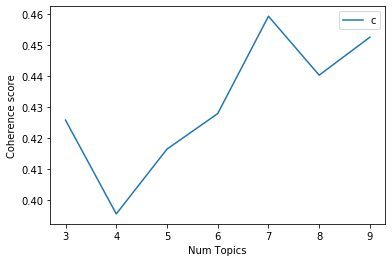

In [164]:
limit = 10
start = 3
step = 1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [165]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4258
Num Topics = 4  has Coherence Value of 0.3955
Num Topics = 5  has Coherence Value of 0.4164
Num Topics = 6  has Coherence Value of 0.4279
Num Topics = 7  has Coherence Value of 0.4593
Num Topics = 8  has Coherence Value of 0.4403
Num Topics = 9  has Coherence Value of 0.4525


In [170]:
mallet_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

## Sentiment

In [171]:
def vader_analysis(text):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)

In [172]:
def polarity(text):
    analysis = TextBlob(text)
    return analysis.sentiment[0]

def subjectivity(text):
    analysis = TextBlob(text)
    return analysis.sentiment[1]

In [211]:
def topic_sent(sentence_tokens):
    s_tokens = sentence_tokens
    topic_0 = 0
    topic_1 = 0
    topic_2 = 0
    topic_3 = 0
    topic_4 = 0
    topic_5 = 0
    topic_6 = 0
    num_sentences = len(s_tokens)
    for i in range(num_sentences):
        tokens = s_tokens[i].split()
        vec = id2word.doc2bow(tokens)
        # model can be changed
        topic = sorted(tfidf_lda_model[vec], key=lambda tup: tup[1], reverse=True)[0][0]
        sentiment = round(100 * vader_analysis(s_tokens[i])['compound'], 2)
        if topic == 0:
            topic_0 += sentiment / num_sentences
        elif topic == 1:
            topic_1 += sentiment / num_sentences
        elif topic == 2:
            topic_2 += sentiment / num_sentences
        elif topic == 3:
            topic_3 += sentiment / num_sentences
        elif topic == 4:
            topic_4 += sentiment / num_sentences
        elif topic == 5:
            topic_5 += sentiment / num_sentences
        else:
            topic_6 += sentiment / num_sentences
    return (round(topic_0, 2), round(topic_1, 2), round(topic_2, 2), round(topic_3, 2), round(topic_4, 2), round(topic_5, 2), round(topic_6, 2))

In [214]:
# Mallet Model
df2 = pd.DataFrame()
df2['Sentiment'] = df['sentence_tokens'].map(topic_sent)

In [188]:
# Topic 0: Elections
# Topic 1: Protests
# Topic 2: Police
# Topic 3: Economic
# Topic 4: Legal/Law
# Topic 5: Government
# Topic 6: Altercations

In [181]:
df2['Elections'] = df2['Sentiment'].map(lambda x: x[0])
df2['Protesters'] = df2['Sentiment'].map(lambda x: x[1])
df2['Police'] = df2['Sentiment'].map(lambda x: x[2])
df2['Economic'] = df2['Sentiment'].map(lambda x: x[3])
df2['Legal/Law'] = df2['Sentiment'].map(lambda x: x[4])
df2['Government'] = df2['Sentiment'].map(lambda x: x[5])
df2['Altercations'] = df2['Sentiment'].map(lambda x: x[6])
df2['Source'] = df['source']

In [182]:
df2.groupby('Source')['Elections'].mean()

Source
ABC (Australia)   -1.776863
CCTV              -0.410659
CNN               -1.980000
Reuters           -1.052304
SCMP              -2.220278
Name: Elections, dtype: float64

In [183]:
df2.groupby('Source')['Protesters'].mean()

Source
ABC (Australia)   -0.305980
CCTV               0.442582
CNN                0.010805
Reuters           -0.563848
SCMP              -1.908940
Name: Protesters, dtype: float64

In [184]:
df2.groupby('Source')['Police'].mean()

Source
ABC (Australia)   -2.308529
CCTV              -3.942363
CNN               -2.266782
Reuters           -2.079839
SCMP              -6.671093
Name: Police, dtype: float64

In [185]:
df2.groupby('Source')['Economic'].mean()

Source
ABC (Australia)   -0.322059
CCTV              -0.542418
CNN               -1.241494
Reuters           -1.447765
SCMP              -1.330843
Name: Economic, dtype: float64

In [222]:
df2.groupby('Source')['Legal/Law'].mean()

Source
ABC (Australia)   -2.273529
CCTV              -4.988077
CNN               -4.987701
Reuters           -2.373871
SCMP              -1.164741
Name: Legal/Law, dtype: float64

In [186]:
df2.groupby('Source')['Government'].mean()

Source
ABC (Australia)   -1.643529
CCTV               0.022473
CNN               -2.271839
Reuters           -1.399124
SCMP              -1.615245
Name: Government, dtype: float64

In [187]:
df2.groupby('Source')['Altercations'].mean()

Source
ABC (Australia)   -9.315000
CCTV              -2.624396
CNN               -3.959425
Reuters           -4.642857
SCMP              -5.998106
Name: Altercations, dtype: float64

In [ ]:
# Topic 0: Protesters
# Topic 1: Legal Issues
# Topic 2: Government/Law
# Topic 3: Government Officials
# Topic 4: Police
# Topic 5: HKer Sentiment
# Topic 6: Economic

In [212]:
# TF-IDF Model
df3 = pd.DataFrame()
df3['Sentiment'] = df['sentence_tokens'].map(topic_sent)

In [213]:
df3['Protesters'] = df3['Sentiment'].map(lambda x: x[0])
df3['Legal Issues'] = df3['Sentiment'].map(lambda x: x[1])
df3['Government/Law'] = df3['Sentiment'].map(lambda x: x[2])
df3['Government Officials'] = df3['Sentiment'].map(lambda x: x[3])
df3['Police'] = df3['Sentiment'].map(lambda x: x[4])
df3['HKer Sentiment'] = df3['Sentiment'].map(lambda x: x[5])
df3['Economic'] = df3['Sentiment'].map(lambda x: x[6])
df3['Source'] = df['source']

In [215]:
df3.groupby('Source')['Protesters'].mean()

Source
ABC (Australia)   -7.031373
CCTV              -3.654451
CNN               -4.585632
Reuters           -3.568157
SCMP              -8.982722
Name: Protesters, dtype: float64

In [216]:
df3.groupby('Source')['Legal Issues'].mean()

Source
ABC (Australia)    0.000000
CCTV               0.000000
CNN                0.000000
Reuters            0.000000
SCMP              -0.001157
Name: Legal Issues, dtype: float64

In [217]:
df3.groupby('Source')['Government/Law'].mean()

Source
ABC (Australia)   -4.503725
CCTV              -3.670495
CNN               -4.467586
Reuters           -3.546935
SCMP              -3.415620
Name: Government/Law, dtype: float64

In [218]:
df3.groupby('Source')['Government Officials'].mean()

Source
ABC (Australia)   -0.366176
CCTV              -1.233791
CNN               -1.500115
Reuters           -0.723641
SCMP              -0.313481
Name: Government Officials, dtype: float64

In [219]:
df3.groupby('Source')['Police'].mean()

Source
ABC (Australia)   -5.960980
CCTV              -3.484505
CNN               -4.055632
Reuters           -4.671429
SCMP              -7.408167
Name: Police, dtype: float64

In [220]:
df3.groupby('Source')['HKer Sentiment'].mean()

Source
ABC (Australia)    0.0
CCTV               0.0
CNN                0.0
Reuters            0.0
SCMP               0.0
Name: HKer Sentiment, dtype: float64

In [221]:
df3.groupby('Source')['Economic'].mean()

Source
ABC (Australia)   -0.082843
CCTV               0.000055
CNN               -2.087701
Reuters           -1.049585
SCMP              -0.788069
Name: Economic, dtype: float64